# Needed libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from astroquery.vizier import Vizier
import sys
import scipy
from time import time
import healpy as hp
from itertools import product
from tqdm import tqdm
from scipy.stats import ks_2samp

In [2]:
# Directory setup for custom modules
module_path = 'EagleEye/eagleeye'
sys.path.append(module_path)
import EagleEye
import From_data_to_binary

# Custom Functions

In [3]:
##################################
####### EAGLEEYE FUNCTIONS #######
##################################
# Function to compute the Upsilon (𝛶) values from binary sequences
def compute_upsilon_values(binary_sequences, neighbor_range, num_cores):
    """Calculates the Upsilon values for anomaly detection using p-values across a range of neighbors."""
    # Create a PValueCalculatorParallel instance to access both pval_array_dict and smallest_pval_info
    p_value_calculator = EagleEye.PValueCalculatorParallel(binary_sequences, kstar_range=neighbor_range, num_cores=num_cores)
    
    # Calculate Upsilon values (𝛶) as the negative log of minimum p-values
    p_value_data = p_value_calculator.smallest_pval_info
    upsilon_values = -np.log(np.array(p_value_data['min_pval']))
    kstar_values = np.array(p_value_data['kstar_min_pval'])
    
    # Return both the calculator instance and the computed Upsilon values and k-star values
    return p_value_calculator, upsilon_values, kstar_values

# Function to retrieve Upsilon values for specific indices
def extract_upsilon_values(pval_info, indices, neighbor_range):
    """Extracts Upsilon values for given indices over a specified neighbor range."""
    return [[-np.log(pval_info.pval_array_dict[k][index, 0]) for k in neighbor_range] for index in indices]

# Function to find indices of interest based on Upsilon and k-star thresholds
def find_indices_by_threshold(upsilon_values, kstar_values, upsilon_thresh, kstar_thresh, condition='>'):
    """Finds indices where Upsilon and k-star values meet specified thresholds."""
    if condition == '>':
        indices = np.where((upsilon_values > upsilon_thresh) & (kstar_values < kstar_thresh))[0]
    else:
        indices = np.where((upsilon_values < upsilon_thresh) & (kstar_values > kstar_thresh))[0]
    return indices

In [4]:
# Function to plot the Upsilon sequences
def plot_nlpval(ax, nlpval1, nlpval2, nlpval3, label1, label2, label3,crit_v):
    ax.plot(range(4, len(nlpval1) + 4), nlpval1, color='limegreen', linewidth=2, label=label1)
    ax.plot(range(4, len(nlpval2) + 4), nlpval2, color='darkorange', linewidth=2, label=label2)
    ax.plot(range(4, len(nlpval3) + 4), nlpval3, color='magenta', linewidth=2, label=label2)
    # Apply logarithmic scale if necessary
    ax.set_yscale('log')
    # Highlight max values
    max_idx1 = np.argmax(nlpval1) + 4
    max_idx2 = np.argmax(nlpval2) + 4
    max_idx3 = np.argmax(nlpval3) + 4

    # ax.axvline(max_idx1, color='darkcyan', linestyle='--', linewidth=1.5, label=f'{label1} Kstar')
    # ax.axvline(max_idx2, color='red', linestyle='--', linewidth=1.5, label=f'{label2} Kstar')

    ax.axhline(y=crit_v, color='red', linestyle='--', linewidth=1.5, label='Crit. value')
    # ax.text(max_idx1, max(nlpval1), 'Kstar', color='darkcyan', verticalalignment='bottom', horizontalalignment='right', fontsize=17, fontweight='bold')
    # ax.text(max_idx2, max(nlpval2), 'Kstar', color='red', verticalalignment='bottom', horizontalalignment='right', fontsize=17, fontweight='bold')

    arrowprops_settings = dict(facecolor='darkcyan', edgecolor='darkcyan', shrink=0.05, width=2, headwidth=10, headlength=10)
    ax.annotate('', xy=(max_idx1, max(nlpval1)), xytext=(max_idx1, max(nlpval1) * 1.5),  # Slight adjustment for log scale
                arrowprops=arrowprops_settings)

    arrowprops_settings_red = dict(facecolor='chocolate', edgecolor='chocolate', shrink=0.05, width=2, headwidth=10, headlength=10)
    ax.annotate('', xy=(max_idx2, max(nlpval2)), xytext=(max_idx2, max(nlpval2) * 1.5),  # Slight adjustment for log scale
                arrowprops=arrowprops_settings_red)
    
    arrowprops_settings_mag = dict(facecolor='darkmagenta', edgecolor='darkmagenta', shrink=0.05, width=2, headwidth=10, headlength=10)
    ax.annotate('', xy=(max_idx3, max(nlpval3)), xytext=(max_idx3, max(nlpval3) * 1.5),  # Slight adjustment for log scale
                arrowprops=arrowprops_settings_mag)

    # Add 'Crit. value' text above the critical value line
    ax.text(395, crit_v * 1.1, 'Crit. line', color='red', fontsize=12, fontweight='bold',
            verticalalignment='bottom', horizontalalignment='right')


    ax.set_ylabel(r'$\Upsilon_i$', rotation=90)
    ax.set_xlim(0, 400-1)
    # ax.set_ylim(-5, max( [20, max(nlpval1), max(nlpval2)] )+10)
    ax.set_xlabel('K-nearest neighbors')
    # ax.legend(loc='upper right')

In [5]:
def LoadBkg(obs, glon_center, glat_center, eps_lon = 0, eps_lat = 0, row_limit = None, size = 2, reference = 'sim', ref_par = 2):
    
    gcenter = SkyCoord(frame="galactic", l = glon_center, b = glat_center, unit=(u.deg, u.deg))
    ra_center = gcenter.transform_to('icrs').ra.value
    dec_center = gcenter.transform_to('icrs').dec.value
    
    v = Vizier(columns=['RAICRS','DEICRS','pmRA','pmDE'],
               column_filters={"Host":"1"}, row_limit = -1)
    
    bkg = v.query_region(SkyCoord(ra = ra_center, dec=dec_center, unit=(u.deg, u.deg),frame='icrs'),
                            width= str(size) + "d",
                            catalog=["VI/137/gum_mw"])
    
    equatorial_coords = SkyCoord( ra  = bkg[0]['RAICRS'], 
                                  dec = bkg[0]['DEICRS'], 
                                  pm_ra_cosdec =  bkg[0]['pmRA'], 
                                  pm_dec = bkg[0]['pmDE'], 
                                  frame = 'icrs')
    
    # Transform to Galactic coordinates
    galactic_coords = equatorial_coords.transform_to('galactic')
    glon_full = galactic_coords.l.value
    glat_full = galactic_coords.b.value
    
    # Access proper motion in Galactic coordinates
    pmlon_full = galactic_coords.pm_l_cosb.to(u.mas/u.yr).value  # Proper motion in Galactic longitude (l)
    pmlat_full = galactic_coords.pm_b.to(u.mas/u.yr).value       # Proper motion in Galactic latitude (b)
    
    full = np.vstack((glon_full, glat_full, pmlon_full, pmlat_full)).T
        
    glon_dw = (obs[:,2] * 180/np.pi - 90) + glon_center + eps_lon # Just to center the dwarf galaxy
    glat_dw = (obs[:,3] * 180/np.pi - 30) + glat_center + eps_lat
    pmlon_dw = obs[:,5] / 1e3
    pmlat_dw = obs[:,6] / 1e3
    dw_data = np.vstack((glon_dw, glat_dw, pmlon_dw, pmlat_dw)).T

    if reference == 'sim':
        glon_ref = glon_center + 5
        glat_ref = glat_center
        gref = SkyCoord(frame="galactic", l = glon_ref, b = glat_ref, unit=(u.deg, u.deg))
        
        ra_ref = gref.transform_to('icrs').ra.value
        dec_ref = gref.transform_to('icrs').dec.value
        
        v = Vizier(columns=['RAICRS','DEICRS','pmRA','pmDE'],
                   column_filters={"Host":"1"}, row_limit = -1)
        
        ref = v.query_region(SkyCoord(ra = ra_ref, dec=dec_ref, unit=(u.deg, u.deg),frame='icrs'),
                                width= str(size + ref_par) + "d",
                                catalog=["VI/137/gum_mw"])
        
        equatorial_coords = SkyCoord( ra  = ref[0]['RAICRS'], 
                                      dec = ref[0]['DEICRS'], 
                                      pm_ra_cosdec =  ref[0]['pmRA'], 
                                      pm_dec = ref[0]['pmDE'], 
                                      frame = 'icrs')
        
        # Transform to Galactic coordinates
        galactic_coords = equatorial_coords.transform_to('galactic')
        glon_ref = galactic_coords.l.value - glon_ref + glon_center # To center around the same longitud
        glat_ref = galactic_coords.b.value
        
        # Access proper motion in Galactic coordinates
        pmlon_ref = galactic_coords.pm_l_cosb.to(u.mas/u.yr).value  # Proper motion in Galactic longitude (l)
        pmlat_ref = galactic_coords.pm_b.to(u.mas/u.yr).value       # Proper motion in Galactic latitude (b)
        
        ref = np.vstack((glon_ref, glat_ref, pmlon_ref, pmlat_ref)).T
        
    if reference == 'noisy':
        ref = np.copy(full)
        ref[:,0] = ref[:,0] + np.random.normal(0, np.std(dw_data[:,0]) / ref_par, len(ref[:,0]))
        ref[:,1] = ref[:,1] + np.random.normal(0, np.std(dw_data[:,1]) / ref_par, len(ref[:,1]))
        ref[:,2] = ref[:,2] + np.random.normal(0, np.std(dw_data[:,2]) / ref_par, len(ref[:,2]))
        ref[:,3] = ref[:,3] + np.random.normal(0, np.std(dw_data[:,3]) / ref_par, len(ref[:,3]))
        
    if row_limit is not None:
        np.random.shuffle(full)
        full = full[:row_limit]
        
        np.random.shuffle(ref)
        ref = ref[:row_limit]
        
    full = np.vstack((full, dw_data))

    return full, ref, dw_data

In [118]:
def purity(upsilon, ind, up_th = 20):
    '''
    Function to compute the purity of the cluster found by EE.

    Parameters
    ----------

    upsilon: (np.array) upsilon values of all the analized stars.
    ind: (np.array int) indices of the stars that trully belong to the dwarf galaxy.
    up_th: (float) upsilon threshold. default = 20

    Returns
    -------

    Purity defined as # dwarf stars (upsilon >= up_th) / # stars (upsilon >= up_th)
    '''
    return len(np.where(upsilon[ind] >= up_th)[0]) / len(np.where(upsilon >= up_th)[0])

def FPR(upsilon, ind, up_th = 20):
    '''
    Function to compute the false positive rate of the cluster found by EE.

    Parameters
    ----------

    upsilon: (np.array) upsilon values of all the analized stars.
    ind: (np.array int) indices of the stars that trully belong to the dwarf galaxy.
    up_th: (float) upsilon threshold. default = 20

    Returns
    -------

    False positive rate defined as # non-dwarf stars with upsilon >= up_th / # bkg stars
    '''
    ind_aux = np.arange(len(upsilon))
    ind_aux = np.delete(ind_aux, ind)
    return len(np.where(upsilon[ind_aux] >= up_th)[0]) / len(ind_aux)
    
def FNR(upsilon, ind, up_th = 20):
    '''
    Function to compute the dwarf stars missed by EE. (False Negative Rate)

    Parameters
    ----------

    upsilon: (np.array) upsilon values of all the analized stars.
    ind: (np.array int) indices of the stars that trully belong to the dwarf galaxy.
    up_th: (float) upsilon threshold. default = 20

    Returns
    -------

    FNR defined as # dwarf stars (upsilon < up_th) / # dwarf stars
    '''
    return len(np.where(upsilon[ind] < up_th)[0]) / len(ind)

def Delta(full, upsilon, ind, up_th = 20):
    '''
    Function to compute the distances (angular and peculiar velocity) between the center of the cluster found by EE
        and the dwarf galaxy.

    Parameters
    ----------

    full: (np.array) data of the analized stars.    
    upsilon: (np.array) upsilon values of all the analized stars.
    ind: (np.array int) indices of the stars that trully belong to the dwarf galaxy.
    up_th: (float) upsilon threshold. default = 20

    Returns
    -------

    Distances defined as 
        ang = np.sqrt( (l_{real} - <l>)^{2} + (b_{real} - <b>)^{2} )
        vpec = np.sqrt( (mul_{real} - <mul>)^{2} + (mub_{real} - <mub>)^{2} )
    '''
    l_real = np.mean(full[ind,0])
    b_real = np.mean(full[ind,1])
    mul_real = np.mean(full[ind,2])
    mub_real = np.mean(full[ind,3])

    ind_aux = np.where(upsilon >= up_th)[0]
    l_cluster = np.mean(full[ind_aux, 0])
    b_cluster = np.mean(full[ind_aux, 1])
    mul_cluster = np.mean(full[ind_aux, 2])
    mub_cluster = np.mean(full[ind_aux, 3])
    
    return np.sqrt( (l_real - l_cluster)**2 + (b_real - b_cluster)**2 ), \
           np.sqrt( (mul_real - mul_cluster)**2 + (mub_real - mub_cluster)**2 )

In [7]:
color_cl = 'red'
color_full = 'darkcyan'
color_dw = 'coral'
color_ref = 'black'

labels = ['$l$ [°]','$b$ [°]','$\mu_{l}$ [mas/yr]','$\mu_{b}$ [mas/yr]']



def plotDwarf(ax, dw_data, full = None, ref = None, indices = None, nbins = 20):
    bins = [np.linspace(np.mean(dw_data[:,0]) - 2, np.mean(dw_data[:,0]) + 2, nbins),
            np.linspace(np.mean(dw_data[:,1]) - 2, np.mean(dw_data[:,1]) + 2, nbins),
            np.linspace(np.mean(dw_data[:,2]) - 3, np.mean(dw_data[:,2]) + 3, nbins),
            np.linspace(np.mean(dw_data[:,3]) - 3, np.mean(dw_data[:,3]) + 3, nbins)]

    lims = [(np.mean(dw_data[:,0]) - 2, np.mean(dw_data[:,0]) + 2),
            (np.mean(dw_data[:,1]) - 2, np.mean(dw_data[:,1]) + 2),
            (np.mean(dw_data[:,2]) - 3, np.mean(dw_data[:,2]) + 3),
            (np.mean(dw_data[:,3]) - 3, np.mean(dw_data[:,3]) + 3)]

    if indices is not None: 
        cluster = full[indices,:] 
    else: 
        cluster = None
    
    for i in range(4):
        for j in range(4):
            if i < j: ax[i,j].set_axis_off()
            if i > j:
                #ax[i,j].set_xlim(lims[j])
                ax[i,j].set_ylim(lims[i])
                if cluster is not None: ax[i,j].scatter(cluster[:,j], cluster[:,i], edgecolor = color_cl, label = 'Cl', 
                                                        marker = 'o', s = 20, facecolor = 'none')
                if ref is not None: ax[i,j].scatter(ref[:,j], ref[:,i], color = color_ref, label = 'Ref', marker = '.', s = 5)
                if full is not None: ax[i,j].scatter(full[:,j], full[:,i], color = color_full, label = 'Bkg', marker = '.', s = 5)
                ax[i,j].scatter(dw_data[:,j], dw_data[:,i], color = color_dw, label = 'Dwarf', marker = '+')
            if i == j:
                if ref is not None: ax[i,j].hist(ref[:,i], histtype = 'step', density = True, bins = bins[i], color = color_ref)
                if full is not None: ax[i,j].hist(full[:,i], histtype = 'step', density = True, bins = bins[i], color = color_full)
                ax[i,j].hist(dw_data[:,i], histtype = 'step', density = True, bins = bins[i], color = color_dw)
                if cluster is not None: ax[i,j].hist(cluster[:,i], histtype = 'step', density = True, bins = bins[i], color = color_cl)
            if i == 3: 
                ax[i,j].set_xlabel(labels[j])
            #else:
             #   ax[i,j].set_xticks([])
            if j == 0: 
                ax[i,j].set_ylabel(labels[i])
            else: 
                ax[i,j].set_yticks([])
        
    ax[0,0].set_xlim(lims[0])
    ax[3,1].set_xlim(lims[1])
    ax[3,2].set_xlim(lims[2])
    ax[3,3].set_xlim(lims[3])
    
    ax[1,0].legend(loc = 'upper right', bbox_to_anchor = (2,2))
    return ax

# Let's start the analysis

In [259]:
# Let's load the true data for the galaxies
ifile = 96
data = np.loadtxt('../data/mocks/library.survey.UFGX_LIB' + str(ifile) + '.dat')

In [267]:
# Generate 100,000 Bernoulli sequences to determine the critical Upsilon threshold
num_sequences = 1000            # Number of Bernoulli sequences
K_M = 500                        # Length of each sequence
NUM_CORES = 50
NEIGHBOR_RANGE = range(4, K_M)
critical_quantile = 0.9999        # Quantile to calculate critical Upsilon threshold


validation  = 1000         # Number of samples to use for validation
kstar_range = range(20, K_M) # Range of kstar values to consider

In [268]:
nside = 1
NPIX = hp.nside2npix(nside)
glat, glon = np.degrees(hp.pix2ang(nside, np.arange(NPIX)))
glat = 90 - glat
len(np.where(np.abs(glat) > 20)[0])

8

In [269]:
glon = glon[np.abs(glat) > 20]

In [270]:
glat = glat[np.abs(glat) > 20]

In [275]:
len(glon)

8

In [274]:
counter

8

In [ ]:
niter = 4#len(glat)#10 # Number of iterations per galaxy
Props = np.zeros(((len(data) * niter), 3)) # Let's initialize the properties array

Ids        = []
ang_sizes  = []
vpec_sizes = []
nstars     = []
pur        = []
falseNegR  = []
falsePosR  = []
dang       = []
dvpec      = []
bkg        = []
glats      = []
glons      = []

indices      = []
upsilons     = []
upsilons_na  = []
kstars       = []
kstars_na    = []
upsilons_val = []
kstars_val   = []

counter = 0
for igal in range(3):
#igal = 621#np.random.randint(len(data))
    start = time()
    for iiter in range(niter):
        
        Ids.append(int(data[igal,0]))
        ang_sizes.append( data[igal,13] )
        vpec_sizes.append( data[igal,14] )
        
        
        obs = np.loadtxt('../data/mocks/obs.lib' + str(ifile) + '/UFGX_TEST' + str(ifile) + '_lib/obs_' + str(int(Ids[counter])) + '.dat')
        print(len(obs))
        nstars.append( len(obs) )
        
        full, ref, dw_data = LoadBkg(obs, glon_center = glon[iiter], glat_center = glat[iiter],
                                     eps_lat = 0, eps_lon = 0, row_limit = None, size = 3)
        
        ind = np.arange(len(full))[-len(dw_data):]
        
        # Begin calls to EagleEye (new version)
        binary_sequences = From_data_to_binary.create_binary_array_cdist(full, ref, num_neighbors = K_M, 
                                                                         num_cores = NUM_CORES, validation = validation, partition_size = 10)
        stats = EagleEye.calculate_p_values(binary_sequences, kstar_range = kstar_range, validation = validation, num_cores = NUM_CORES)
        # Extract the test and validation statistics!
        upsilon, kstar, upsilon_val, kstar_val = stats['Upsilon_i'],stats['kstar_'],stats['Upsilon_i_Val'],stats['kstar_Val']
        
        binary_sequences_na = From_data_to_binary.create_binary_array_cdist(full[:-len(dw_data)], ref, num_neighbors = K_M, 
                                                                         num_cores = NUM_CORES, validation = validation, partition_size = 10)
        stats_na = EagleEye.calculate_p_values(binary_sequences_na, kstar_range = kstar_range, validation = validation, num_cores = NUM_CORES)
        # Extract the test and validation statistics!
        upsilon_na, kstar_na, upsilon_val_na, kstar_val_na = stats_na['Upsilon_i'],stats_na['kstar_'],stats_na['Upsilon_i_Val'],stats_na['kstar_Val']
        
        # ---------------------------------------------------------------------------------
        
        upsilons.append(upsilon)
        upsilons_na.append(upsilon_na)
        kstars.append(kstar)
        kstars_na.append(kstar_na)
        upsilons_val.append(upsilon_val)
        kstars_val.append(kstar_val)
        glons.append(glon[iiter])
        glats.append(glat[iiter])
        up_th = np.quantile(upsilon, 0.8)
        indices.append(np.where(upsilon >= up_th)[0])
        pur.append(purity(upsilon, ind, up_th = up_th))
        falseNegR.append(FNR(upsilon, ind, up_th = up_th))
        falsePosR.append(FPR(upsilon, ind, up_th = up_th))
        aux1, aux2 = Delta(full, upsilon, ind, up_th = up_th)
        dang.append(aux1)
        dvpec.append(aux2)
        bkg.append((len(full) - len(dw_data)))
        
        counter = counter + 1
    stop = time()
    print('It takes {:.2f} hs to analyze a dwarf with {} stars at {} positions'.format((stop-start)/3600, len(dw_data), niter))


371
Validation size is:  1000


In [277]:
nups = 100

aux_pur = np.zeros((len(upsilons), nups))
aux_FNR = np.zeros((len(upsilons), nups))
aux_FPR = np.zeros((len(upsilons), nups))

for ipos in range(len(upsilons)):
    upsilon = upsilons[ipos]
    ind = np.arange(len(upsilon))[-nstars[ipos]:]
    up_range = np.linspace(np.min(upsilon), np.max(upsilon), nups)
    
    for iups in range(nups):
        aux_pur[ipos, iups] = purity(upsilon, ind, up_th = up_range[iups])
        aux_FNR[ipos, iups] = FNR(upsilon, ind, up_th = up_range[iups])
        aux_FPR[ipos, iups] = FPR(upsilon, ind, up_th = up_range[iups])

In [285]:
len(upsilons)

12

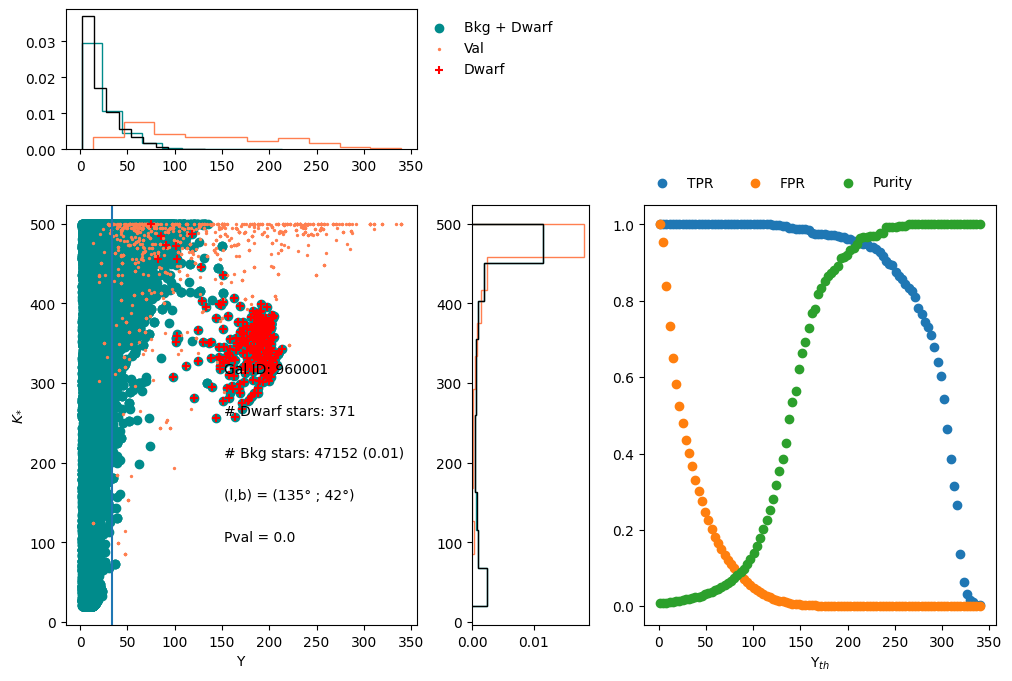

In [287]:
i = 1
statistic, p_value = ks_2samp(upsilons[i], upsilons_na[i])

fig,ax = plt.subplots(2,3, gridspec_kw = {'width_ratios':[3,1,3], 'height_ratios':[1,3]},
                     #sharex = 'col', sharey = 'row',
                      figsize = (12,8))

#plt.subplots_adjust()
ax[0,0].hist(upsilons[i], histtype = 'step', density = True, color = 'darkcyan')
ax[0,0].hist(upsilons_val[i], histtype = 'step', density = True, color = 'coral')
#ax[0,0].hist(upsilons[i][-len(dw_data):], histtype = 'step', density = True, color = 'red')
ax[0,0].hist(upsilons_na[i], histtype = 'step', density = True, color = 'black')

ax[0,1].set_axis_off()

ax[1,0].scatter(upsilons[i], kstars[i], label = 'Bkg + Dwarf', color = 'darkcyan')
ax[1,0].scatter(upsilons_val[i], kstars_val[i], label = 'Val', color = 'coral', s = 2)
ax[1,0].scatter(upsilons[i][-nstars[i]:], kstars[i][-nstars[i]:], label = 'Dwarf', color = 'red', marker = '+')
ax[1,0].legend(loc = 'upper right', bbox_to_anchor = (1.42,1.47), frameon = False)
ax[1,0].axvline(x = up_th)

ax[1,1].hist(kstars[i], histtype = 'step', density = True, color = 'darkcyan', orientation='horizontal')
ax[1,1].hist(kstars_val[i], histtype = 'step', density = True, color = 'coral', orientation='horizontal')
#ax[1,1].hist(kstars[i][-len(dw_data):], histtype = 'step', density = True, color = 'red', orientation='horizontal')
ax[1,1].hist(kstars_na[i], histtype = 'step', density = True, color = 'black', orientation='horizontal')

ax[1,0].set_xlabel('$\\Upsilon$')
ax[1,0].set_ylabel('$K_{*}$')

ax[1,0].text(0.45, 0.6,'Gal ID: {}'.format(Ids[i]), transform = ax[1,0].transAxes)
ax[1,0].text(0.45, 0.5,'# Dwarf stars: {}'.format(nstars[i]), transform = ax[1,0].transAxes)
ax[1,0].text(0.45, 0.4,'# Bkg stars: {} ({:.2f})'.format(len(upsilons[i]) - nstars[i], nstars[i] / (len(upsilons[i]) - nstars[i])), transform = ax[1,0].transAxes)
ax[1,0].text(0.45, 0.3,'(l,b) = ({:.0f}° ; {:.0f}°)'.format(glons[i], glats[i]), transform = ax[1,0].transAxes)
ax[1,0].text(0.45, 0.2,'Pval = {:.1f}'.format(p_value), transform = ax[1,0].transAxes)

ax[0,2].set_axis_off()
ax[1,2].scatter(up_range, (1-aux_FNR[i,:]), label = 'TPR')
ax[1,2].scatter(up_range, aux_FPR[i,:], label = 'FPR')
ax[1,2].scatter(up_range, aux_pur[i,:], label = 'Purity')
ax[1,2].set_xlabel('$\\Upsilon_{th}$')
ax[1,2].legend(loc = 'upper right', bbox_to_anchor = (0.80,1.10), frameon = False, ncol = 3)

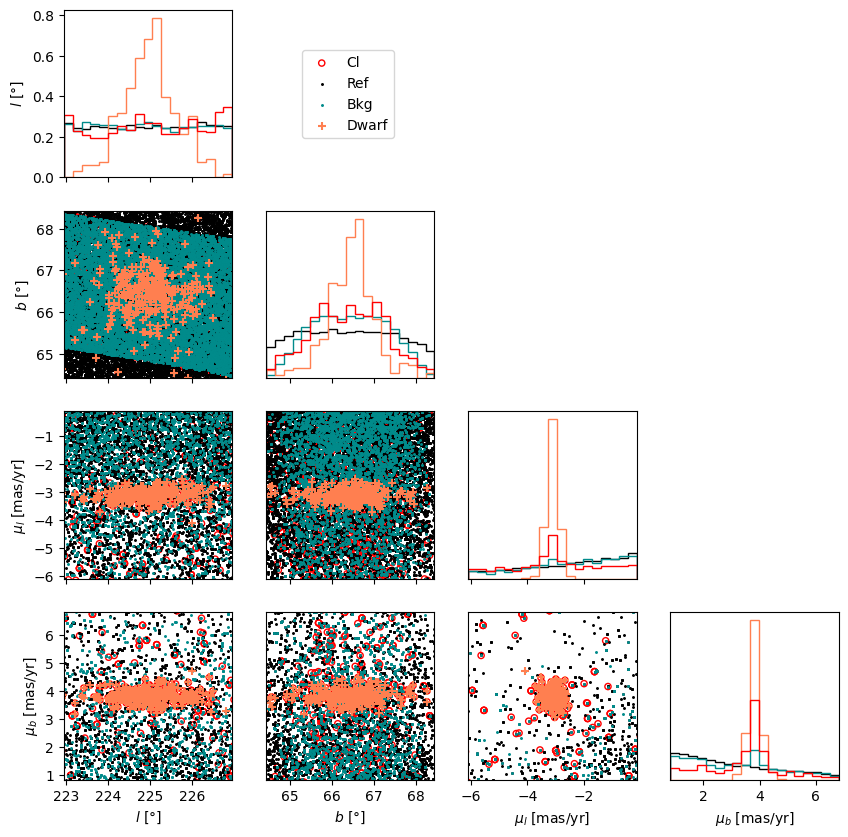

In [76]:
fig, ax  = plt.subplots(4,4, figsize = (10,10), sharex = 'col')

plt.subplots_adjust(hspace = 0.2, wspace = 0.2)

ax = plotDwarf(ax, dw_data, full, ref, indices[0])

#plt.savefig('../graph/gal_{}_4d.pdf'.format(Id), bbox_inches='tight')

In [168]:
glat, glon = np.degrees(hp.pix2ang(nside, np.arange(NPIX)))
glat = 90 - glat

for ipur in range(nups):
#ipur = 0
    pur = aux_pur[:,ipur]
    mapa = np.zeros(NPIX)  # Array 1D de ejemplo
    mapa[np.where(np.abs(glat) > 20)[0]] = pur
    
    # Graficar el mapa en coordenadas Mollweide
    hp.mollview(mapa, title="", unit="Purity", cmap="viridis")
    
    plt.text(0, 1.1, "$\\Upsilon = ${:.2f}".format(up_range[ipur]), fontsize=12, color='black', ha='center')
    
    plt.savefig('../graph/960622/gif/Moolview_{}_pur.png'.format(ipur), bbox_inches='tight')
    plt.close()

In [251]:
aux_pur.shape

(16, 100)

Text(0, 1.1, '$\\Upsilon = $210.19')

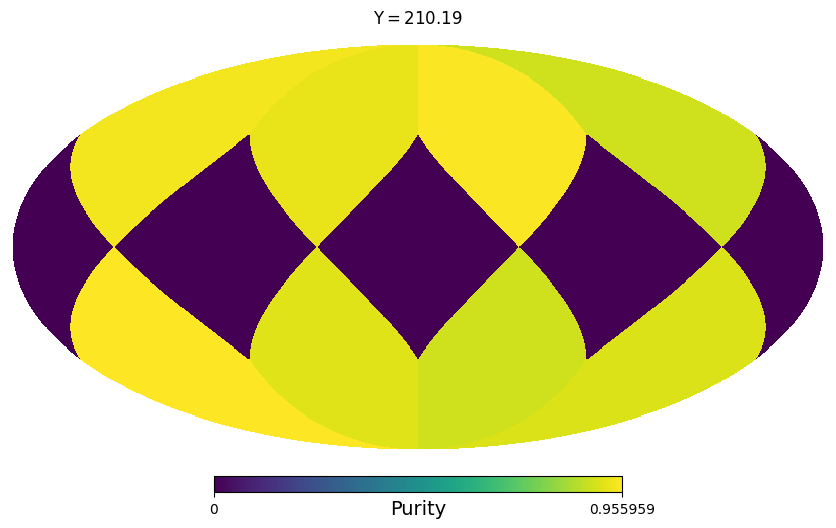

In [255]:
glat, glon = np.degrees(hp.pix2ang(nside, np.arange(NPIX)))
glat = 90 - glat

ipur = 60
pur = aux_pur[:8,ipur]
mapa = np.zeros(NPIX)  # Array 1D de ejemplo
mapa[np.where(np.abs(glat) > 20)[0]] = pur

# Graficar el mapa en coordenadas Mollweide
hp.mollview(mapa, title="", unit="Purity", cmap="viridis")

plt.text(0, 1.1, "$\\Upsilon = ${:.2f}".format(up_range[ipur]), fontsize=12, color='black', ha='center')